In [1]:
from ultralytics import YOLO
import random
import matplotlib.pyplot as plt
import cv2 as cv
import os
import numpy as np
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
model_version = "train_tuned2"
number_test_images = 5

In [3]:
def extract_bounding_box_from_data_set(img_name):

    img_width = 1024
    img_height = 128

    with open(os.path.join(PATH_val + '/labels', img_name).replace('.jpg', '.txt'), 'r') as file:
        contents = file.read()
    contents = contents.strip().split('\n')

    # Extract bounding box coordinates without the class label
    bounding_boxes = []
    for line in contents:
        parts = line.split()  # Split the line into parts
        coords = list(map(float, parts[1:]))  # Skip the first element (class label) and convert the rest to float
        
        # Convert YOLO percentages to real coordinates
        x_center = coords[0] * img_width
        y_center = coords[1] * img_height
        width = coords[2] * img_width
        height = coords[3] * img_height

        # Calculate real bounding box coordinates
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)

        # Append as [x_min, y_min, x_max, y_max]
        bounding_boxes.append([x_min, y_min, x_max, y_max])
    bounding_boxes_array = np.array(bounding_boxes).astype(int)

    return bounding_boxes_array

print(os.getcwd())

PATH_train = os.getenv('PATH_TO_TRAIN_DATA')
PATH_val = os.getenv('PATH_TO_VAL_DATA')

assert os.path.exists(PATH_train), 'PATH_TO_TRAIN_DATA is not valid'
assert os.path.exists(PATH_val), 'PATH_TO_VAL_DATA is not valid'

model = YOLO(f'../{model_version}/weights/best.pt')
sample_images = random.sample(os.listdir(PATH_val + '/images'), number_test_images)

/cluster/home/tristanw/tdt17-mini-project/model



image 1/1 /cluster/projects/vc/data/ad/open/Poles/test/images/combined_image_152_png.rf.dd6e37b561bd56b24efcf543741bd23b.jpg: 128x800 3 poles, 2751.3ms
Speed: 22.3ms preprocess, 2751.3ms inference, 22.9ms postprocess per image at shape (1, 3, 128, 800)

image 1/1 /cluster/projects/vc/data/ad/open/Poles/test/images/combined_image_637_png.rf.2069c003a40a840a1e115e782e6b1f96.jpg: 128x800 3 poles, 28.7ms
Speed: 0.9ms preprocess, 28.7ms inference, 0.8ms postprocess per image at shape (1, 3, 128, 800)

image 1/1 /cluster/projects/vc/data/ad/open/Poles/test/images/combined_image_1981_png.rf.3a641ce0d242b7c8435fa43c998524f1.jpg: 128x800 2 poles, 29.1ms
Speed: 0.9ms preprocess, 29.1ms inference, 0.9ms postprocess per image at shape (1, 3, 128, 800)

image 1/1 /cluster/projects/vc/data/ad/open/Poles/test/images/combined_image_1452_png.rf.31c8bd655513004a30fe30a85e5452bd.jpg: 128x800 2 poles, 49.8ms
Speed: 0.9ms preprocess, 49.8ms inference, 0.7ms postprocess per image at shape (1, 3, 128, 800)


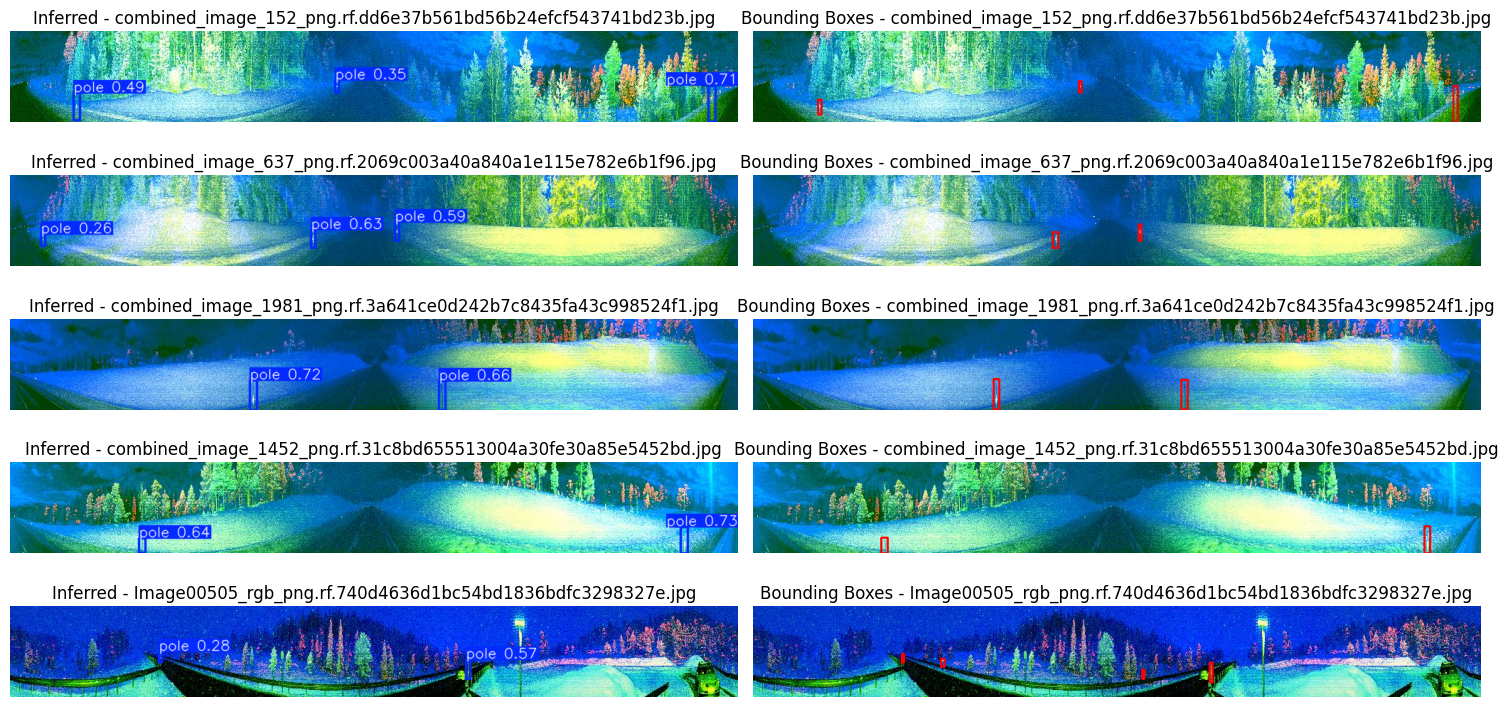

In [4]:
fig, axes = plt.subplots(len(sample_images), 2, figsize=(15, 1.5 * len(sample_images)))

for i, img_name in enumerate(sample_images):
    # Plot 1: Inferred results
    results = model(os.path.join(PATH_val + '/images', img_name), device='cpu')
    infered = results[0].plot()
    infered = cv.cvtColor(infered, cv.COLOR_BGR2RGB)
    axes[i, 0].imshow(infered)
    axes[i, 0].set_title(f"Inferred - " + img_name)
    axes[i, 0].axis("off")

    # Plot 2: Bounding box annotations
    img = cv.imread(os.path.join(PATH_val + '/images', img_name))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    bounding_boxes = extract_bounding_box_from_data_set(img_name)
    if len(bounding_boxes) > 0:
        for box in bounding_boxes:
            img = cv.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
    axes[i, 1].imshow(img)
    axes[i, 1].set_title(f"Bounding Boxes - " + img_name)
    axes[i, 1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()


image 1/1 /cluster/projects/vc/data/ad/open/Poles/test/images/combined_image_152_png.rf.dd6e37b561bd56b24efcf543741bd23b.jpg: 128x800 3 poles, 28.4ms
Speed: 1.0ms preprocess, 28.4ms inference, 0.8ms postprocess per image at shape (1, 3, 128, 800)
Performing prediction on 2 slices.

image 1/1 /cluster/projects/vc/data/ad/open/Poles/test/images/combined_image_637_png.rf.2069c003a40a840a1e115e782e6b1f96.jpg: 128x800 3 poles, 27.3ms
Speed: 0.8ms preprocess, 27.3ms inference, 0.8ms postprocess per image at shape (1, 3, 128, 800)
Performing prediction on 2 slices.

image 1/1 /cluster/projects/vc/data/ad/open/Poles/test/images/combined_image_1981_png.rf.3a641ce0d242b7c8435fa43c998524f1.jpg: 128x800 2 poles, 74.4ms
Speed: 0.8ms preprocess, 74.4ms inference, 0.8ms postprocess per image at shape (1, 3, 128, 800)
Performing prediction on 2 slices.

image 1/1 /cluster/projects/vc/data/ad/open/Poles/test/images/combined_image_1452_png.rf.31c8bd655513004a30fe30a85e5452bd.jpg: 128x800 2 poles, 28.2m

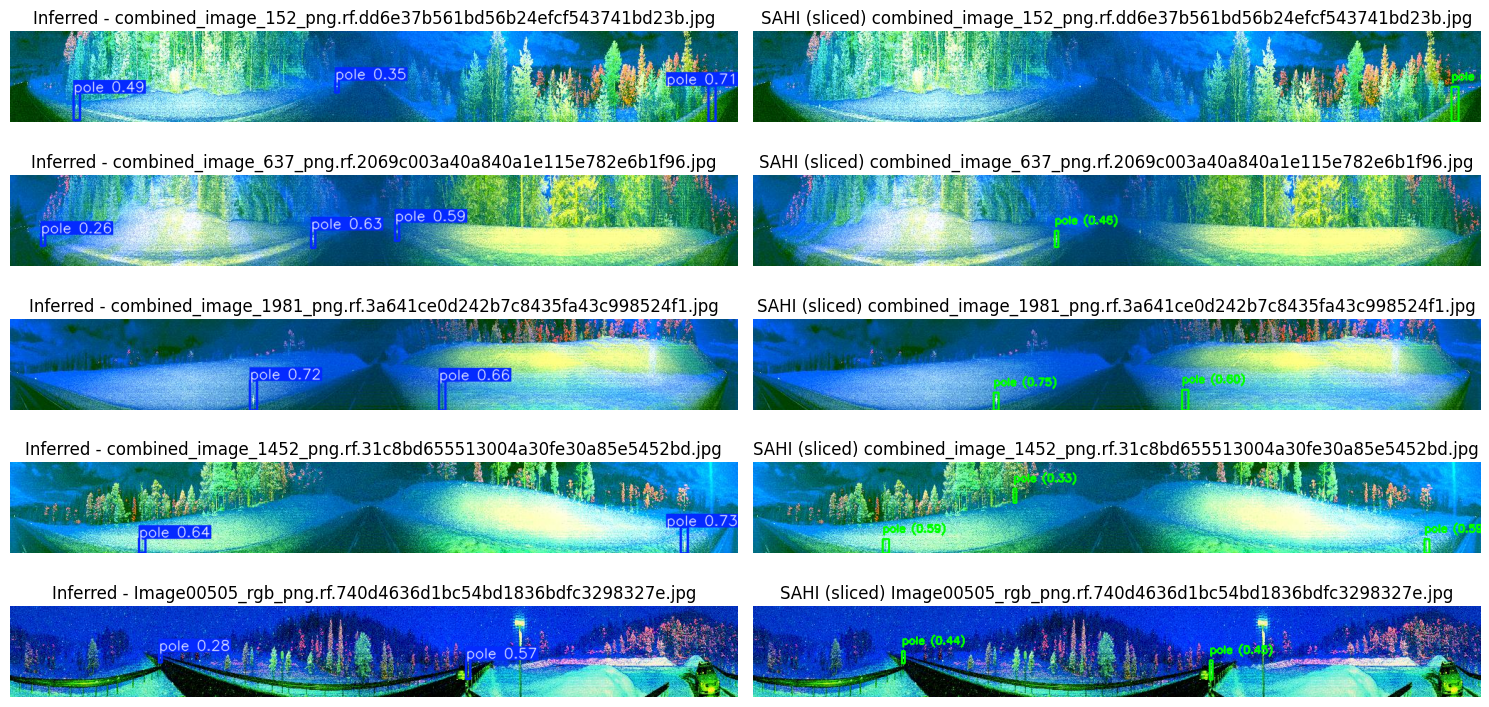

In [5]:
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction

fig, axes = plt.subplots(len(sample_images), 2, figsize=(15, 1.5 * len(sample_images)))

detection_model_sahi = AutoDetectionModel.from_pretrained(
    model_type="yolov8",  # SAHI uses 'yolov8' as the model type for YOLOv8 and above
    model_path=f'../{model_version}/weights/best.pt',
    confidence_threshold=0.3,
    device='cuda',
)

for i, img_name in enumerate(sample_images):
    # Plot 1: Inferred results
    results = model(os.path.join(PATH_val + '/images', img_name), device='cpu')
    infered = results[0].plot()
    infered = cv.cvtColor(infered, cv.COLOR_BGR2RGB)
    axes[i, 0].imshow(infered)
    axes[i, 0].set_title(f"Inferred - " + img_name)
    axes[i, 0].axis("off")

    # Plot 2: Bounding box annotations
    img = cv.imread(os.path.join(PATH_val + '/images', img_name))

    result = get_sliced_prediction(
    img,
    detection_model_sahi,
    slice_height=800 - 32 * 2,
    slice_width=800 - 32 * 2,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
    )

    predictions = result.object_prediction_list
    overlay = img.copy()

    for box in predictions:
        bbox = box.bbox
        score = box.score.value
        name = box.category.name

        x1 = int(bbox.minx)
        y1 = int(bbox.miny)
        x2 = int(bbox.maxx)
        y2 = int(bbox.maxy)
        label = f"{name} ({score:.2f})"

        roi = overlay[y1:y2, x1:x2]  # Region of interest
        brighter_roi = cv.convertScaleAbs(roi, alpha=1.5, beta=50)
        overlay[y1:y2, x1:x2] = brighter_roi

        cv.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv.putText(img, label, (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    axes[i, 1].imshow(img)
    axes[i, 1].set_title(f"SAHI (sliced) " + img_name)
    axes[i, 1].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()